# The food vision 101 project

> Konstantinos Mpouros <br>
> Github: https://github.com/konstantinosmpouros <br>
> Year: 2024 <br>

Thi project is about to rival the CNN model that was build and publiced by the authors of the paper <b>[DeepFood: Deep Learning-Based Food Image Recognition for Computer-Aided Dietary Assessment 2016](https://www.researchgate.net/publication/304163308_DeepFood_Deep_Learning-Based_Food_Image_Recognition_for_Computer-Aided_Dietary_Assessment)</b>. The paper addresses the challenge of accurately documenting dietary caloric intake, which is crucial for managing weight loss and understanding dietary habits. Traditional methods for dietary assessment, such as 24-hour recalls and food frequency questionnaires, rely on an individual's memory, which can introduce bias and inaccuracies. To overcome these limitations, the paper proposes a computer-aided technical solution using deep learning-based food image recognition algorithms. <b>The core innovation of the paper is the development of a new Convolutional Neural Network (CNN)-based algorithm for food image recognition with the highest score reaching 77,4%</b>.

So our goal is to create a CNN that reach or surpass this score in the same dataset <b>(Food-101)</b>.

|                 | 🍔🍝 About the Bataset 🥪🥞 |
|-----------------|-------------------------------|
| Dataset source  |      TensorFlow Datasets      | 
| Train data      |         75,750 images         | 
| Test data       |         25,250 images         | 
| Mixed precision |              Yes              |
| Data loading    |    Performanant tf.data API   |  
| Target results  |      77.4% top-1 accuracy     | 

## Load libraries

In [1]:
# Helper Functions
from helper_functions import plot_loss_accuracy_curves
from helper_functions import random_img_show
from helper_functions import walk_through_dir
from helper_functions import preprocess_img
from helper_functions import check_models_have_close_weights

# Data manipulation
import pandas as pd
import numpy as np

# Modeling and Mixed percision training
import tensorflow as tf
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from tensorflow.keras import mixed_precision

2024-03-16 13:11:17.010584: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-16 13:11:17.033726: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-16 13:11:17.033738: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-16 13:11:17.034229: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-16 13:11:17.037769: I tensorflow/core/platform/cpu_feature_guar

## Data Exploration

> Access the data images from the tensorflow datasets

In [2]:
# Load in the data (this wi ll take some time..)
(train_data, test_data), ds_info = tfds.load(name="food101", # target dataset to get from TFDS
                                             split=["train", "validation"], # what splits of data should we get? note: not all datasets have train, valid, test
                                             shuffle_files=True, # shuffle files on download?
                                             as_supervised=True, # download data in tuple format (sample, label), e.g. (image, label)
                                             with_info=True,
                                             data_dir='Dataset/'
                                            )

2024-03-16 13:11:18.083120: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:11:18.100727: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:11:18.100773: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:11:18.103185: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-16 13:11:18.103223: I external/local_xla/xla/stream_executor

> A directory walk throught that we can see each directory and the number of images inside

In [3]:
walk_through_dir('Dataset/')

There are 2 directories and 0 images in 'Dataset/'.
There are 1 directories and 2 images in 'Dataset/downloads'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted'.
There are 1 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz'.
There are 2 directories and 2 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101'.
There are 101 directories and 0 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cvl_food-1012X0V5Di39EmPlghqT34vpCoy8nEuh9MpVEGytjFAU6Q.tar.gz/food-101/images/apple_pie'.
There are 0 directories and 1000 images in 'Dataset/downloads/extracted/TAR_GZ.data.vision.ee.ethz.ch_cv

In [4]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

> Class labels presentation

In [5]:
class_names = ds_info.features['label'].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [6]:
print(len(class_names))

101


> Plot random images

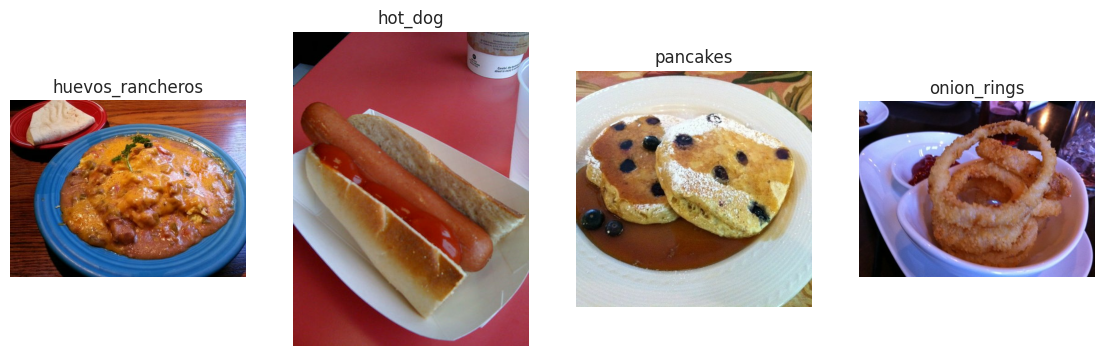

In [7]:
random_img_show(train_data, class_names)

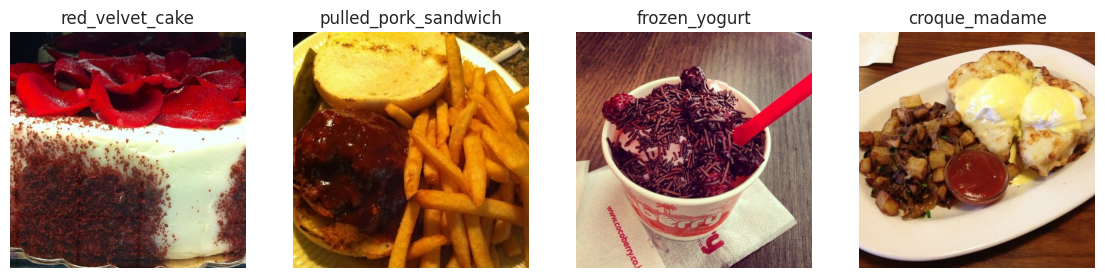

In [8]:
random_img_show(test_data, class_names)

> The images in both train and test dataset have no standar shape

In [9]:
# Output info about our training sample
for image, label in train_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (341, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 98
  Class name (str form): tiramisu
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 65
  Class name (str form): mussels
        


In [10]:
# Output info about our training sample
for image, label in test_data.take(2):
  print(f"""
  Image shape: {image.shape}
  Image dtype: {image.dtype}
  Target class from Food101 (tensor form): {label}
  Class name (str form): {class_names[label.numpy()]}
        """)


  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 83
  Class name (str form): red_velvet_cake
        

  Image shape: (512, 512, 3)
  Image dtype: <dtype: 'uint8'>
  Target class from Food101 (tensor form): 16
  Class name (str form): cheesecake
        


> Shape variance in both train and test datasets

In [11]:
train_shape_variance = set()

for image, label in train_data:
    train_shape_variance.add(image.shape)
    
train_shape_variance

{TensorShape([122, 512, 3]),
 TensorShape([140, 512, 3]),
 TensorShape([165, 512, 3]),
 TensorShape([181, 512, 3]),
 TensorShape([182, 512, 3]),
 TensorShape([188, 512, 3]),
 TensorShape([210, 512, 3]),
 TensorShape([218, 512, 3]),
 TensorShape([220, 512, 3]),
 TensorShape([222, 512, 3]),
 TensorShape([225, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([228, 512, 3]),
 TensorShape([229, 512, 3]),
 TensorShape([230, 512, 3]),
 TensorShape([231, 512, 3]),
 TensorShape([232, 512, 3]),
 TensorShape([236, 512, 3]),
 TensorShape([239, 512, 3]),
 TensorShape([241, 512, 3]),
 TensorShape([243, 512, 3]),
 TensorShape([246, 512, 3]),
 TensorShape([247, 512, 3]),
 TensorShape([249, 512, 3]),
 TensorShape([252, 512, 3]),
 TensorShape([253, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([257, 512, 3]),
 TensorShape([259, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([265, 512, 3]),
 TensorShape([266, 512, 3]),
 TensorShape([267, 512, 3]),
 TensorShape([

In [12]:
len(train_shape_variance)

448

In [13]:
test_shape_variance = set()

for image, label in test_data:
    test_shape_variance.add(image.shape)

test_shape_variance

{TensorShape([213, 512, 3]),
 TensorShape([226, 512, 3]),
 TensorShape([254, 512, 3]),
 TensorShape([256, 512, 3]),
 TensorShape([260, 512, 3]),
 TensorShape([262, 512, 3]),
 TensorShape([268, 512, 3]),
 TensorShape([271, 512, 3]),
 TensorShape([272, 512, 3]),
 TensorShape([276, 512, 3]),
 TensorShape([281, 512, 3]),
 TensorShape([282, 512, 3]),
 TensorShape([287, 512, 3]),
 TensorShape([288, 512, 3]),
 TensorShape([289, 512, 3]),
 TensorShape([290, 512, 3]),
 TensorShape([291, 512, 3]),
 TensorShape([293, 512, 3]),
 TensorShape([294, 512, 3]),
 TensorShape([295, 512, 3]),
 TensorShape([298, 512, 3]),
 TensorShape([299, 512, 3]),
 TensorShape([301, 512, 3]),
 TensorShape([304, 512, 3]),
 TensorShape([305, 512, 3]),
 TensorShape([306, 512, 3]),
 TensorShape([307, 512, 3]),
 TensorShape([308, 512, 3]),
 TensorShape([309, 512, 3]),
 TensorShape([310, 512, 3]),
 TensorShape([312, 512, 3]),
 TensorShape([313, 512, 3]),
 TensorShape([314, 512, 3]),
 TensorShape([316, 512, 3]),
 TensorShape([

In [14]:
len(test_shape_variance)

302

> Images will also need normalization

In [15]:
for image, label in train_data.take(1):
    print(image.numpy())

[[[189 165 121]
  [185 161 117]
  [181 157 113]
  ...
  [111  72  33]
  [103  64  25]
  [ 94  55  16]]

 [[186 162 118]
  [183 159 115]
  [180 156 112]
  ...
  [122  83  40]
  [113  74  31]
  [105  66  23]]

 [[180 156 112]
  [178 154 110]
  [177 153 109]
  ...
  [132  94  45]
  [124  87  35]
  [120  83  31]]

 ...

 [[207 204 159]
  [205 201 154]
  [204 196 147]
  ...
  [231 225 191]
  [231 225 189]
  [231 226 188]]

 [[207 204 159]
  [205 201 154]
  [204 196 147]
  ...
  [230 224 190]
  [230 224 188]
  [229 223 187]]

 [[206 203 158]
  [204 200 153]
  [203 195 146]
  ...
  [229 223 189]
  [228 222 186]
  [228 222 186]]]


In [16]:
tf.reduce_min(image).numpy(), tf.reduce_max(image).numpy()

(0, 255)

## Pre-modeling Preparation

> In order to process tha images efficiently and train the model the faster that we can, we will need to modify the images and the way that the images are processed by the gpu and cpu. So, we will create batches of the images and enable the multitasking of the computer in order to load batches of images and augment them, while the gpu is training the model with the previous batch of images.

In [17]:
# Map preprocessing function to training data (and paralellize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Shuffle train_data and turn it into batches and prefetch it (load it faster)
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [18]:
# Map prepreprocessing function to test data
test_data = test_data.map(preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

# Turn test data into batches (don't need to shuffle)
test_data = test_data.batch(32).prefetch(tf.data.AUTOTUNE)

test_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 227, 227, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

> Lets also create callback functions that will save our models progress and to early stop our models training if the model doesn't learn anything in a amount of epochs.

In [19]:
# Initialize the path that will save the model
checkpoint_path = "model_checkpoints/cp.ckpt" # saving weights requires ".ckpt" extension

# Create ModelCheckpoint callback to save model's progress
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_accuracy", # save the model weights with best validation accuracy
                                                      save_best_only=True, # only save the best weights
                                                      save_weights_only=True, # only save model weights (not whole model)
                                                      verbose=0, # don't print out whether or not model is being saved 
                                                     ) 

In [20]:
# Setup EarlyStopping callback to stop training if model's val_loss doesn't improve for 5 epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_acc", # watch the val loss metric
                                                  patience=2, # if val loss decreases for 2 epochs in a row, stop training
                                                 )

In [21]:
# Creating learning rate reduction callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7)

## Modeling

> Before moving on stronger method of image classification we will try to create our own CNN to see if we can come close to the objective accuracy.

In [32]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [33]:
mixed_precision.set_global_policy(policy='mixed_float16')

In [34]:
mixed_precision.global_policy()

<Policy "mixed_float16">

In [38]:
input_shape = (227, 227, 3)

own_model = tf.keras.Sequential([
    layers.Input(shape=input_shape),
    layers.Rescaling(1/255),
    layers.Conv2D(96, 11, strides=4, activation='relu', name='Conv1'),
    layers.MaxPool2D(3, strides=2),
    layers.Conv2D(256, 5, strides=1, activation='relu', name='Conv2'),
    layers.MaxPool2D(3, strides=1),
    layers.Conv2D(384, 3, strides=1, activation='relu', name='Conv3'),
    layers.Conv2D(384, 3, strides=1, activation='relu', name='Conv4'),
    layers.MaxPool2D(3, strides=1),
    layers.Conv2D(256, 3, strides=1, activation='relu', name='Conv5'),
    layers.Conv2D(256, 3, strides=1, activation='relu', name='Conv6'),
    layers.MaxPool2D(3, strides=1),
    layers.Conv2D(256, 3, strides=1, activation='relu', name='Conv7'),
    layers.MaxPool2D(3, strides=1),
    layers.
    layers.Flatten(),
    layers.Dense(6216, activation='relu'),
    layers.Dense(2096, activation='relu'),
    layers.Dense(2096, activation='relu'),
    layers.Dense(101, activation='softmax')
], name='Own_Model')

own_model.summary()

Model: "Own_Model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_6 (Rescaling)     (None, 227, 227, 3)       0         
                                                                 
 Conv1 (Conv2D)              (None, 55, 55, 96)        34944     
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 27, 27, 96)        0         
 ng2D)                                                           
                                                                 
 Conv2 (Conv2D)              (None, 23, 23, 256)       614656    
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 21, 21, 256)       0         
 ng2D)                                                           
                                                                 
 Conv3 (Conv2D)              (None, 19, 19, 384)       88

In [39]:
for layer in own_model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

rescaling_6 True float32 <Policy "mixed_float16">
Conv1 True float32 <Policy "mixed_float16">
max_pooling2d_26 True float32 <Policy "mixed_float16">
Conv2 True float32 <Policy "mixed_float16">
max_pooling2d_27 True float32 <Policy "mixed_float16">
Conv3 True float32 <Policy "mixed_float16">
Conv4 True float32 <Policy "mixed_float16">
max_pooling2d_28 True float32 <Policy "mixed_float16">
Conv5 True float32 <Policy "mixed_float16">
Conv6 True float32 <Policy "mixed_float16">
max_pooling2d_29 True float32 <Policy "mixed_float16">
Conv7 True float32 <Policy "mixed_float16">
max_pooling2d_30 True float32 <Policy "mixed_float16">
flatten_6 True float32 <Policy "mixed_float16">
dense_24 True float32 <Policy "mixed_float16">
dense_25 True float32 <Policy "mixed_float16">
dense_26 True float32 <Policy "mixed_float16">
dense_27 True float32 <Policy "mixed_float16">


In [41]:
own_model.compile(optimizer='Adam',
                  metrics=['accuracy'],
                  loss='sparse_categorical_crossentropy'
                 )

own_model_history = own_model.fit(train_data,
                                  epochs=4,
                                  steps_per_epoch=len(train_data),
                                  validation_data=test_data,
                                  validation_steps=int(0.15 * len(test_data)),
                                  callbacks=[early_stopping])

Epoch 1/4
2368/2368 [==============================] - 96s 40ms/step - loss: 4.6160 - accuracy: 0.0093 - val_loss: 4.6150 - val_accuracy: 0.0106
Epoch 2/4
2368/2368 [==============================] - 94s 40ms/step - loss: 4.6160 - accuracy: 0.0087 - val_loss: 4.6160 - val_accuracy: 0.0109
Epoch 3/4
2368/2368 [==============================] - 94s 39ms/step - loss: 4.6160 - accuracy: 0.0088 - val_loss: 4.6157 - val_accuracy: 0.0117


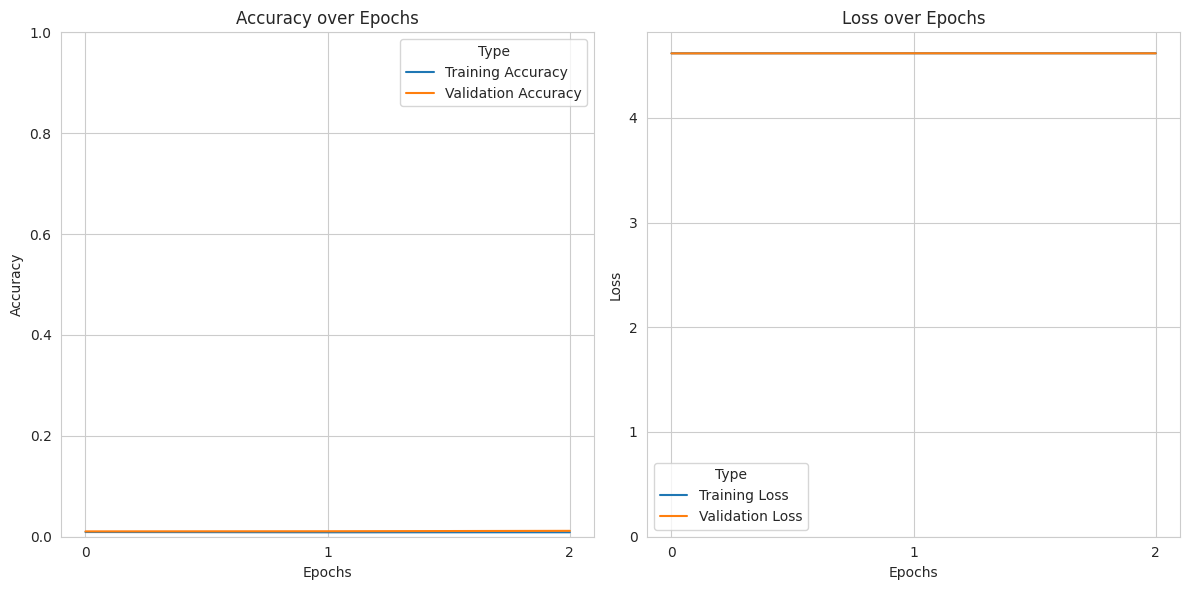

In [42]:
plot_loss_accuracy_curves(own_model_history)

In [43]:
own_model.evaluate(test_data)

790/790 [==============================] - 8s 9ms/step - loss: 4.6156 - accuracy: 0.0099


[4.615591526031494, 0.009900989942252636]

## Transfer Learning

### Feature Extraction

> The modeling is beeing performed in a Geforce RTX 3060 with 12.4 score of computational capabilities. This gpu enables the mixed percision training and the model will train and perform faster than without mixed percision.

In [1]:
!nvidia-smi -L

GPU 0: NVIDIA GeForce RTX 3060 (UUID: GPU-ab9b9fbd-4e42-e44a-c243-d1a9ea6686fe)


In [23]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [24]:
mixed_precision.set_global_policy(policy='mixed_float16')

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


2024-03-10 19:43:14.064224: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 3060, compute capability 8.6


In [25]:
mixed_precision.global_policy()

<Policy "mixed_float16">

> As for the modeling we will used already trained model in the image recognition cause we don't have the resources and the time to create from scratch a model capable to outperforme the model of the paper. So with the help of transfer learning we will take existing models and fine tune them in our situation. The model that we choosen is the **EfficientNetV2B0** and we hope to as its name says. Lets extract the model.

In [26]:
# Create base model
model_name = 'EfficientNetV2B0'
base_model = tf.keras.applications.EfficientNetV2B0(include_top=False, input_shape=input_shape)
base_model.trainable = False # freeze base model layers

In [27]:
print(f'Number of layers: {len(base_model.layers)}')
for number, layer in enumerate(base_model.layers):
    print(f'{number}.  {type(layer).__name__}')

Number of layers: 270
0.  InputLayer
1.  Rescaling
2.  Normalization
3.  Conv2D
4.  BatchNormalization
5.  Activation
6.  Conv2D
7.  BatchNormalization
8.  Activation
9.  Conv2D
10.  BatchNormalization
11.  Activation
12.  Conv2D
13.  BatchNormalization
14.  Conv2D
15.  BatchNormalization
16.  Activation
17.  Conv2D
18.  BatchNormalization
19.  Dropout
20.  Add
21.  Conv2D
22.  BatchNormalization
23.  Activation
24.  Conv2D
25.  BatchNormalization
26.  Conv2D
27.  BatchNormalization
28.  Activation
29.  Conv2D
30.  BatchNormalization
31.  Dropout
32.  Add
33.  Conv2D
34.  BatchNormalization
35.  Activation
36.  DepthwiseConv2D
37.  BatchNormalization
38.  Activation
39.  GlobalAveragePooling2D
40.  Reshape
41.  Conv2D
42.  Conv2D
43.  Multiply
44.  Conv2D
45.  BatchNormalization
46.  Conv2D
47.  BatchNormalization
48.  Activation
49.  DepthwiseConv2D
50.  BatchNormalization
51.  Activation
52.  GlobalAveragePooling2D
53.  Reshape
54.  Conv2D
55.  Conv2D
56.  Multiply
57.  Conv2D
58.  B

> Create the model

In [28]:
# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="avg_pooling_layer")(x)
x = layers.Flatten()(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 

model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

In [29]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

> Ensuring we use mixed precision in our training for faster computations

In [30]:
for layer in model.layers:
    print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

input_layer True float32 <Policy "float32">
efficientnetv2-b0 False float32 <Policy "mixed_float16">
avg_pooling_layer True float32 <Policy "mixed_float16">
flatten True float32 <Policy "mixed_float16">
dense True float32 <Policy "mixed_float16">
softmax_float32 True float32 <Policy "float32">


In [31]:
for layer in base_model.layers[:20]: # only check the first 20 layers to save output space
    print(type(layer).__name__, layer.trainable, layer.dtype, layer.dtype_policy)

InputLayer False float32 <Policy "float32">
Rescaling False float32 <Policy "mixed_float16">
Normalization False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Activation False float32 <Policy "mixed_float16">
Conv2D False float32 <Policy "mixed_float16">
BatchNormalization False float32 <Policy "mixed_float16">
Dropout False float32 <Policy 

> Train the model for some epochs in order to train the new layers we added.

In [32]:
history = model.fit(train_data, 
                    epochs=4,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    validation_steps=int(0.15 * len(test_data)),
                    callbacks=[model_checkpoint, early_stopping])

Epoch 1/4


2024-03-10 19:43:19.343200: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-10 19:43:19.705719: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-10 19:43:19.852456: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


   5/2368 [..............................] - ETA: 1:03 - loss: 4.6894 - accuracy: 0.0063     

2024-03-10 19:43:20.816647: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f5b74003500 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-10 19:43:20.816664: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-03-10 19:43:20.826646: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1710092600.897535    1164 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2368/2368 [==============================] - 68s 27ms/step - loss: 1.7442 - accuracy: 0.5786 - val_loss: 1.1415 - val_accuracy: 0.7034
Epoch 2/4
2368/2368 [==============================] - 62s 26ms/step - loss: 1.2115 - accuracy: 0.6862 - val_loss: 1.0279 - val_accuracy: 0.7254
Epoch 3/4
2368/2368 [==============================] - 62s 26ms/step - loss: 1.0634 - accuracy: 0.7228 - val_loss: 1.0016 - val_accuracy: 0.7270
Epoch 4/4
2368/2368 [==============================] - 62s 26ms/step - loss: 0.9689 - accuracy: 0.7462 - val_loss: 0.9729 - val_accuracy: 0.7381


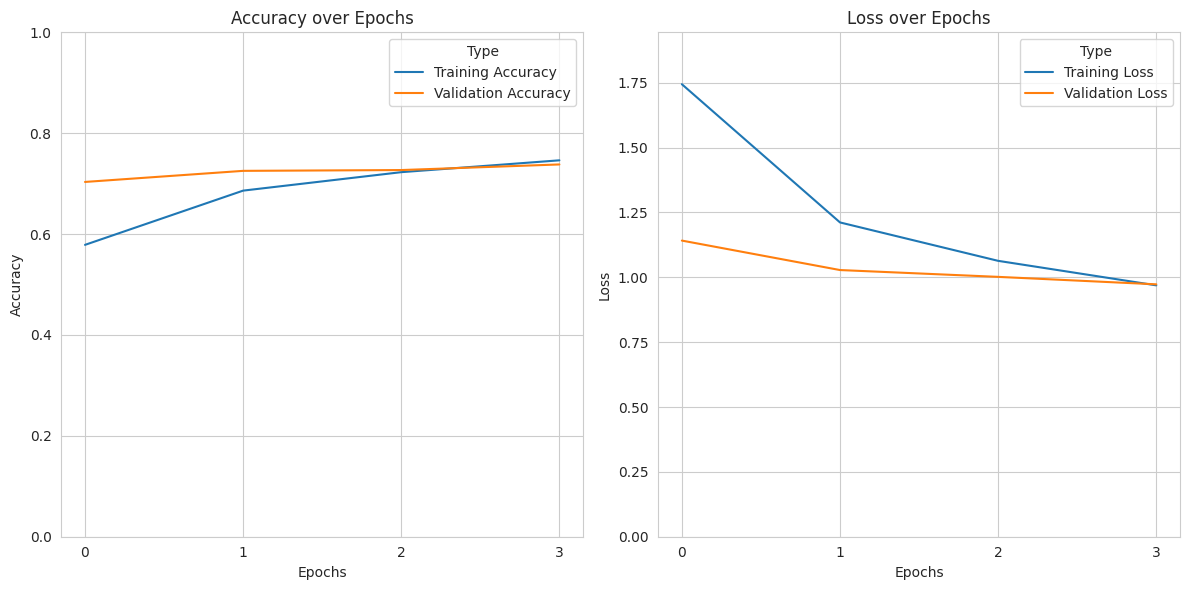

In [33]:
plot_loss_accuracy_curves(history)

In [34]:
model.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9718 - accuracy: 0.7351


[0.9718295335769653, 0.735089123249054]

In [35]:
base_model_path = 'models/base_model/'
model.save(base_model_path)

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf945f2b0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf945f2b0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf92e8910>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf92e8910>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd61a0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd61a0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd73a0>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd73a0>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf945f2b0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf945f2b0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf92e8910>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf92e8910>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd61a0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd61a0>, 140037302276048), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd73a0>, 140037302276208), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5cf8bd73a0>, 140037302276208), {}).


INFO:tensorflow:Assets written to: models/base_model/assets


INFO:tensorflow:Assets written to: models/base_model/assets


### Fine Tuning

#### Last 20 layers

In [36]:
model_ft_l20 = tf.keras.models.load_model(base_model_path)

In [37]:
check_models_have_close_weights(model_ft_l20, model)

Both models have the same weights in all layers


> Lets unfreeze the last layers of the model in order to train the layers that take the decisions of the efficientnet model.

In [38]:
# Unfreeze the layers
model_ft_l20.layers[1].trainable = True
for layer in model_ft_l20.layers[1].layers[:-20]:
    layer.trainable = False

count = 0
for layer in model_ft_l20.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2B0 model: 20


In [39]:
model_ft_l20.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

> Recompile the model in order to adjust the learning rate to x10 lower cause we dont want to modify a lot the weight in the unfrozen layers.

In [40]:
model_ft_l20.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [41]:
fine_tune_l20_history = model_ft_l20.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 82s 33ms/step - loss: 0.8077 - accuracy: 0.7854 - val_loss: 0.8790 - val_accuracy: 0.7593 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 78s 33ms/step - loss: 0.6837 - accuracy: 0.8174 - val_loss: 0.8465 - val_accuracy: 0.7696 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 76s 32ms/step - loss: 0.5666 - accuracy: 0.8481 - val_loss: 0.8865 - val_accuracy: 0.7609 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - ETA: 0s - loss: 0.4543 - accuracy: 0.8792
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 76s 32ms/step - loss: 0.4543 - accuracy: 0.8792 - val_loss: 0.8998 - val_accuracy: 0.7669 - lr: 1.0000e-04


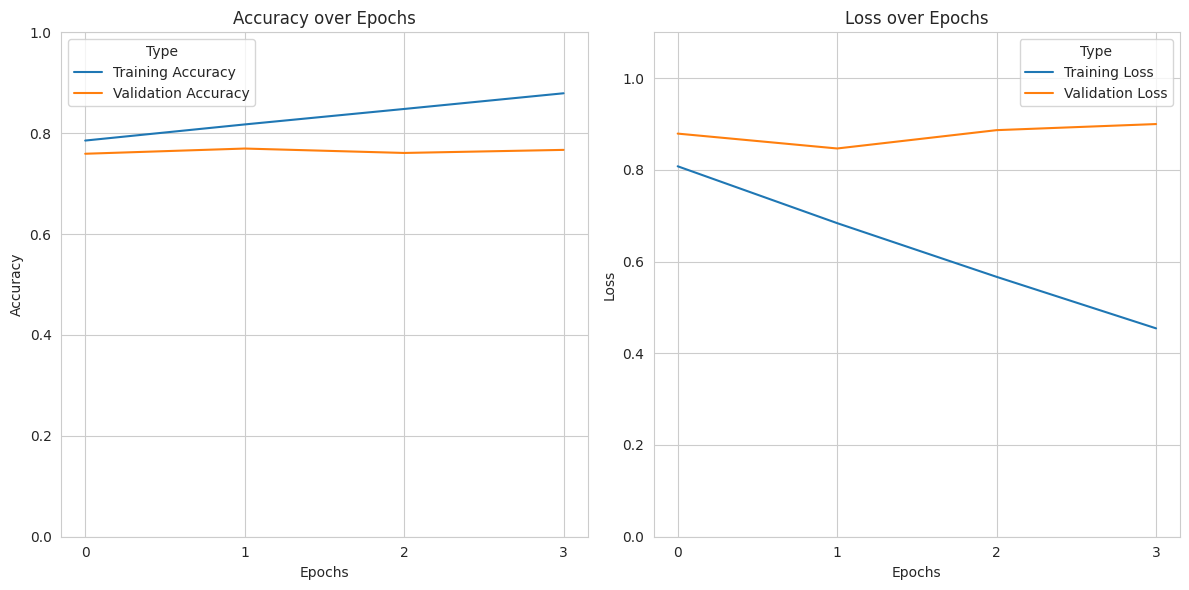

In [42]:
plot_loss_accuracy_curves(fine_tune_l20_history)

In [43]:
model_ft_l20.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9153 - accuracy: 0.7603


[0.9152684211730957, 0.7603168487548828]

#### Last and first 20 layers

In [44]:
model_ft_l20_f20 = tf.keras.models.load_model(base_model_path)

In [45]:
check_models_have_close_weights(model_ft_l20_f20, model)

Both models have the same weights in all layers


In [46]:
# Freeze all layers in efficient net model.
model_ft_l20_f20.layers[1].trainable = True

# Unfreeze the first and last 20 layers
for layer in model_ft_l20_f20.layers[1].layers[20:-20]:
    layer.trainable = False

count = 0
for layer in model_ft_l20_f20.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2B0 model: 40


In [47]:
model_ft_l20_f20.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

In [48]:
model_ft_l20_f20.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [49]:
fine_tune_l20_f20_history = model_ft_l20_f20.fit(train_data,
                                                 epochs=4,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=[early_stopping, reduce_lr]
                                                )

Epoch 1/4
2368/2368 [==============================] - 172s 69ms/step - loss: 0.8013 - accuracy: 0.7866 - val_loss: 0.8521 - val_accuracy: 0.7683 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 167s 70ms/step - loss: 0.6720 - accuracy: 0.8193 - val_loss: 0.8297 - val_accuracy: 0.7752 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 167s 70ms/step - loss: 0.5532 - accuracy: 0.8512 - val_loss: 0.8431 - val_accuracy: 0.7762 - lr: 1.0000e-04
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 0.4394 - accuracy: 0.8820
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 168s 71ms/step - loss: 0.4394 - accuracy: 0.8820 - val_loss: 0.8837 - val_accuracy: 0.7696 - lr: 1.0000e-04


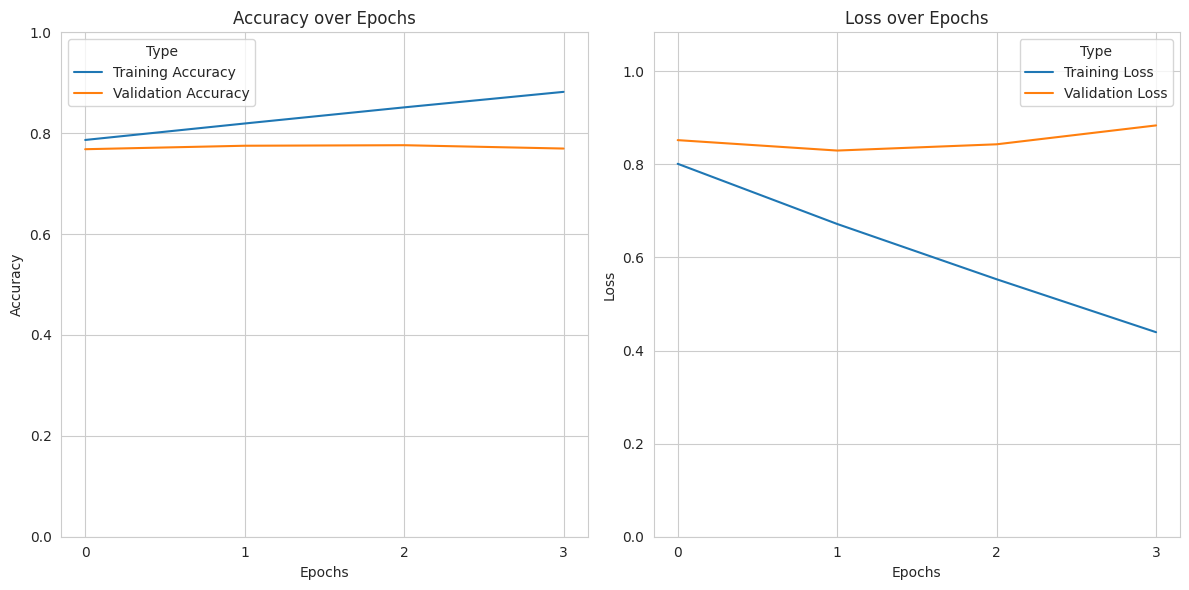

In [50]:
plot_loss_accuracy_curves(fine_tune_l20_f20_history)

In [51]:
model_ft_l20_f20.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.8830 - accuracy: 0.7673


[0.8830252885818481, 0.7673267126083374]

#### Last 50 layers

In [52]:
model_ft_l50 = tf.keras.models.load_model(base_model_path)

In [53]:
check_models_have_close_weights(model_ft_l50, model)

Both models have the same weights in all layers


In [54]:
model_ft_l50.layers[1].trainable = True

for layer in model_ft_l50.layers[1].layers[:-50]:
    layer.trainable = False

count = 0
for layer in model_ft_l50.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2B0 model: 50


In [55]:
model_ft_l50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

In [56]:
model_ft_l50.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [57]:
fine_tune_l50_history = model_ft_l50.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 102s 41ms/step - loss: 0.8036 - accuracy: 0.7851 - val_loss: 0.8498 - val_accuracy: 0.7648 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 99s 42ms/step - loss: 0.6013 - accuracy: 0.8375 - val_loss: 0.8324 - val_accuracy: 0.7746 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 97s 41ms/step - loss: 0.4013 - accuracy: 0.8920 - val_loss: 0.8993 - val_accuracy: 0.7754 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - ETA: 0s - loss: 0.2311 - accuracy: 0.9390
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 97s 41ms/step - loss: 0.2311 - accuracy: 0.9390 - val_loss: 1.0419 - val_accuracy: 0.7553 - lr: 1.0000e-04


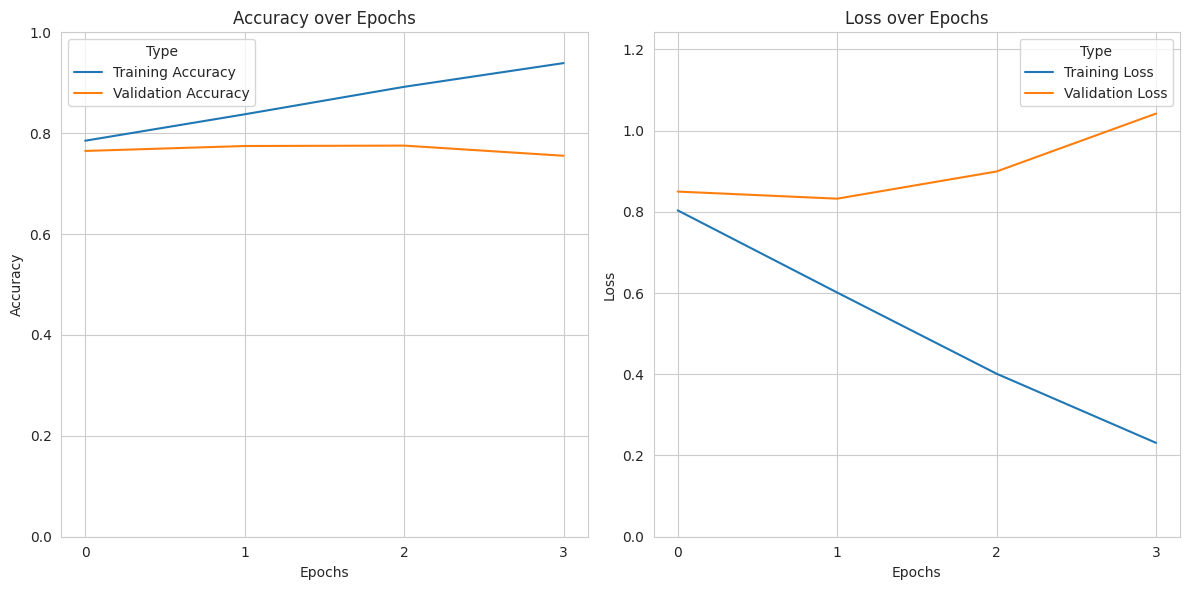

In [58]:
plot_loss_accuracy_curves(fine_tune_l50_history)

In [59]:
model_ft_l50.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 1.0540 - accuracy: 0.7552


[1.0540103912353516, 0.7551683187484741]

#### Last and first 50 layers

In [60]:
model_ft_l50_f50 = tf.keras.models.load_model(base_model_path)

In [61]:
check_models_have_close_weights(model_ft_l50_f50, model)

Both models have the same weights in all layers


In [62]:
model_ft_l50_f50.layers[1].trainable = True

In [63]:
for layer in model_ft_l50_f50.layers[1].layers[50:-50]:
    layer.trainable = False

count = 0
for layer in model_ft_l50_f50.layers[1].layers:
    if layer.trainable:
        count += 1

print(f'Number of layers that are trainable in {model_name} model: {count}')

Number of layers that are trainable in EfficientNetV2B0 model: 100


In [64]:
model_ft_l50_f50.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

In [65]:
model_ft_l50_f50.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [66]:
fine_tune_l50_f50_history = model_ft_l50_f50.fit(train_data,
                                                 epochs=4,
                                                 steps_per_epoch=len(train_data),
                                                 validation_data=test_data,
                                                 validation_steps=int(0.15 * len(test_data)),
                                                 callbacks=[early_stopping, reduce_lr]
                                                 )

Epoch 1/4
2368/2368 [==============================] - 202s 81ms/step - loss: 0.8021 - accuracy: 0.7852 - val_loss: 0.8081 - val_accuracy: 0.7847 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 191s 81ms/step - loss: 0.5856 - accuracy: 0.8392 - val_loss: 0.7823 - val_accuracy: 0.7918 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 191s 80ms/step - loss: 0.3880 - accuracy: 0.8941 - val_loss: 0.8561 - val_accuracy: 0.7802 - lr: 1.0000e-04
Epoch 4/4
2367/2368 [============================>.] - ETA: 0s - loss: 0.2269 - accuracy: 0.9376
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 191s 80ms/step - loss: 0.2269 - accuracy: 0.9376 - val_loss: 0.9421 - val_accuracy: 0.7725 - lr: 1.0000e-04


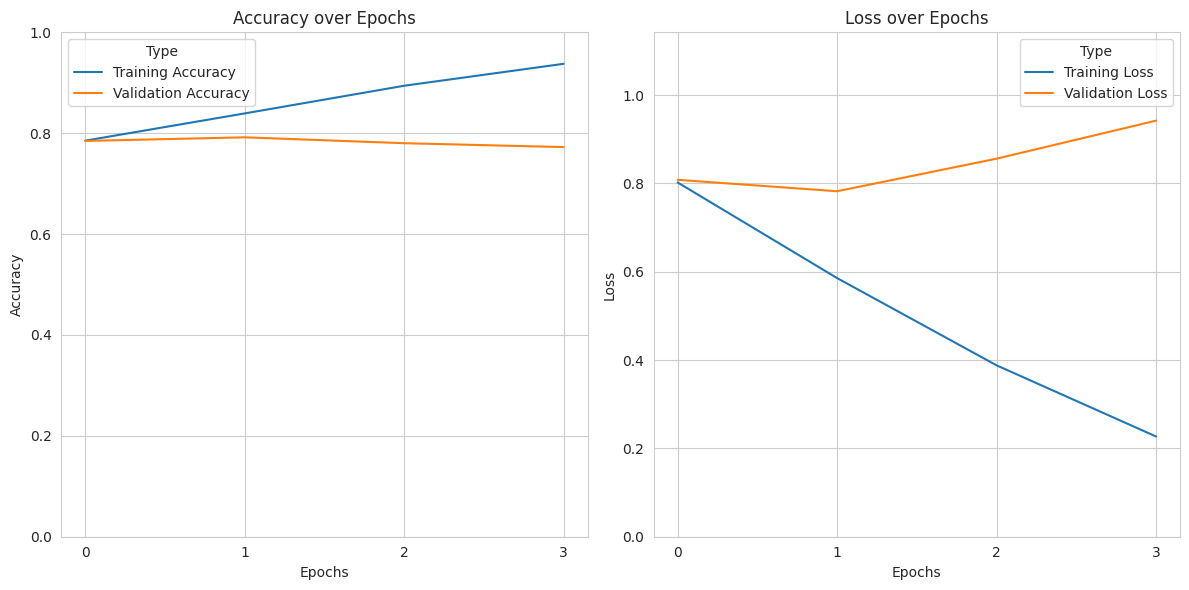

In [67]:
plot_loss_accuracy_curves(fine_tune_l50_f50_history)

In [68]:
model_ft_l50_f50.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9627 - accuracy: 0.7706


[0.9627113342285156, 0.7705742716789246]

#### All layers

In [69]:
model_ft_all = tf.keras.models.load_model(base_model_path)

In [70]:
check_models_have_close_weights(model_ft_all, model)

Both models have the same weights in all layers


In [71]:
model_ft_all.layers[1].trainable = True

In [72]:
model_ft_all.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetv2-b0 (Functio  (None, 7, 7, 1280)        5919312   
 nal)                                                            
                                                                 
 avg_pooling_layer (GlobalA  (None, 1280)              0         
 veragePooling2D)                                                
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0     

In [73]:
model_ft_all.compile(loss='sparse_categorical_crossentropy',
                     optimizer=tf.keras.optimizers.Adam(0.0001), # 10x lower learning rate than the default
                     metrics=['accuracy']
                     )

In [74]:
fine_tune_all_history = model_ft_all.fit(train_data,
                                         epochs=4,
                                         steps_per_epoch=len(train_data),
                                         validation_data=test_data,
                                         validation_steps=int(0.15 * len(test_data)),
                                         callbacks=[early_stopping, reduce_lr]
                                         )

Epoch 1/4
2368/2368 [==============================] - 273s 107ms/step - loss: 0.8289 - accuracy: 0.7757 - val_loss: 0.7395 - val_accuracy: 0.7903 - lr: 1.0000e-04
Epoch 2/4
2368/2368 [==============================] - 248s 104ms/step - loss: 0.4815 - accuracy: 0.8657 - val_loss: 0.7275 - val_accuracy: 0.8046 - lr: 1.0000e-04
Epoch 3/4
2368/2368 [==============================] - 248s 105ms/step - loss: 0.2457 - accuracy: 0.9285 - val_loss: 0.7858 - val_accuracy: 0.8035 - lr: 1.0000e-04
Epoch 4/4
2368/2368 [==============================] - ETA: 0s - loss: 0.1276 - accuracy: 0.9620
Epoch 4: ReduceLROnPlateau reducing learning rate to 1.9999999494757503e-05.
2368/2368 [==============================] - 246s 104ms/step - loss: 0.1276 - accuracy: 0.9620 - val_loss: 0.9081 - val_accuracy: 0.7921 - lr: 1.0000e-04


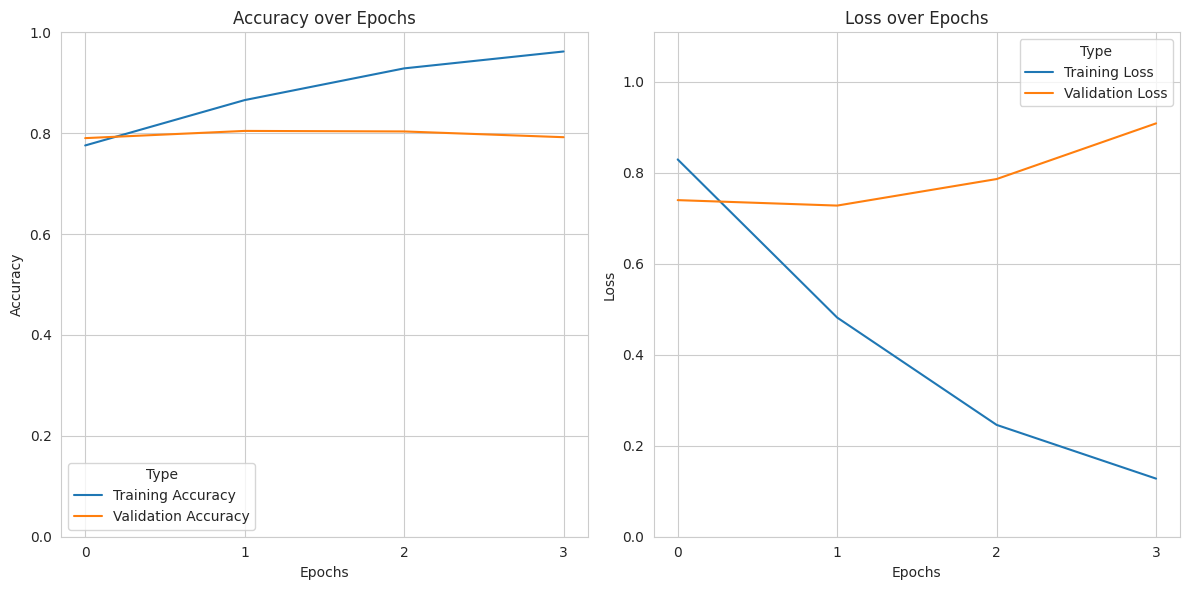

In [75]:
plot_loss_accuracy_curves(fine_tune_all_history)

In [76]:
model_ft_all.evaluate(test_data)

790/790 [==============================] - 17s 21ms/step - loss: 0.9047 - accuracy: 0.7862


[0.9047257900238037, 0.7861782312393188]

## Results

In [77]:
model_ft_all.save('models/fine_tune_model/')

INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401a20>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401a20>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73430eb0>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73430eb0>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73433cd0>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73433cd0>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7347ab30>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7347ab30>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a734c1990>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a734c1990>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330c7f0>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330c7f0>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330f610>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330f610>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7335a470>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7335a470>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a12d0>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a12d0>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73e26650>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73e26650>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73fbfa90>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73fbfa90>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94bf22f0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94bf22f0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94a4b580>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94a4b580>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a9496a560>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a9496a560>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6f0d0>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6f0d0>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6dea0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6dea0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f389a0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f389a0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401ab0>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401ab0>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f062f0>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f062f0>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a947d0580>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a947d0580>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5aacf2f4c0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5aacf2f4c0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4373e50>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4373e50>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372dd0>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372dd0>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372200>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372200>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43e8130>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43e8130>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4ea10>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4ea10>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4c1f0>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4c1f0>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d157b0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d157b0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d15930>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d15930>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d16560>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d16560>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d17a60>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d17a60>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d2f550>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d2f550>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4396920>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4396920>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43babf0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43babf0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43b9d50>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43b9d50>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a21d0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a21d0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a3220>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a3220>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731e8250>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731e8250>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731eb280>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731eb280>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7302e2f0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7302e2f0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306d390>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306d390>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306e3e0>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306e3e0>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306f3d0>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306f3d0>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b4460>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b4460>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b5450>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b5450>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f004c0>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f004c0>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f034f0>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f034f0>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f42560>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f42560>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f435b0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f435b0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f885e0>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f885e0>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f89630>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f89630>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f8a620>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f8a620>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72fc9690>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72fc9690>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0c700>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0c700>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0f730>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0f730>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4c7c0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4c7c0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4d7b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4d7b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4e800>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4e800>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4f7f0>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4f7f0>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e92860>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e92860>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72edd8d0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72edd8d0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d24940>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d24940>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d25990>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d25990>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d26980>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d26980>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d279d0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d279d0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d64a00>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d64a00>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d67a30>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d67a30>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72db2aa0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72db2aa0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72dedb10>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72dedb10>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72deeb60>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72deeb60>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72defb50>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72defb50>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c34be0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c34be0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c35bd0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c35bd0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c78c40>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c78c40>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c7bc70>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c7bc70>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc2ce0>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc2ce0>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc3d30>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc3d30>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0cd60>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0cd60>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0ddb0>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0ddb0>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0eda0>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0eda0>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b51e10>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b51e10>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba0e80>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba0e80>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba3eb0>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba3eb0>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd8f40>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd8f40>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd9f30>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd9f30>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdaf80>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdaf80>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdbf70>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdbf70>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a2afe0>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a2afe0>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a6a050>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a6a050>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab10c0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab10c0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab2110>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab2110>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab3100>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab3100>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af4190>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af4190>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af5180>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af5180>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293c1f0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293c1f0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293f220>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293f220>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297a290>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297a290>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297b2e0>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297b2e0>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cc310>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cc310>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cd360>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cd360>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729ce350>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729ce350>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728113c0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728113c0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72858430>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72858430>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7285b460>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7285b460>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a04f0>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a04f0>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a14e0>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a14e0>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a2530>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a2530>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a3520>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a3520>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728ee590>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728ee590>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72731600>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72731600>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72774670>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72774670>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727756c0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727756c0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727766b0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727766b0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72777700>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72777700>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b0730>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b0730>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b3760>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b3760>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72606800>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72606800>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72649870>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72649870>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264a8c0>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264a8c0>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264b8b0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264b8b0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72690940>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72690940>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72691930>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72691930>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d49a0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d49a0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d79d0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d79d0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7251ca60>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7251ca60>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198d030>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198d030>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198e800>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198e800>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198fd00>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198fd00>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c5240>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c5240>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c6740>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c6740>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c7c40>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c7c40>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180d180>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180d180>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180e680>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180e680>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180fb80>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180fb80>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184d0c0>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184d0c0>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184e5c0>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184e5c0>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184fac0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184fac0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891000>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891000>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891f60>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891f60>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71892e30>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71892e30>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71893dc0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71893dc0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e0cd0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e0cd0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e2200>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e2200>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e3700>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e3700>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171cc40>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171cc40>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171dba0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171dba0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171ea70>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171ea70>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171fa00>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171fa00>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71768910>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71768910>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71769e40>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71769e40>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7176b340>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7176b340>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b0880>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b0880>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b17e0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b17e0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b26b0>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b26b0>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b3640>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b3640>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f4550>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f4550>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f5a80>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f5a80>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f6f80>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f6f80>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716484c0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716484c0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71649420>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71649420>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164a2f0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164a2f0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164b280>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164b280>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71684190>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71684190>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716856c0>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716856c0>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71686bc0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71686bc0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d4100>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d4100>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5060>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5060>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5f30>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5f30>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d6ec0>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d6ec0>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d7d90>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d7d90>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71519300>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71519300>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151a800>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151a800>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151bd00>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151bd00>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71568ca0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71568ca0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71569b70>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71569b70>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156ab00>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156ab00>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156b9d0>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156b9d0>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715acf40>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715acf40>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715ae440>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715ae440>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715af940>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715af940>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f08e0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f08e0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f17b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f17b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f2740>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f2740>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f3670>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f3670>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143cbb0>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143cbb0>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143e0b0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143e0b0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143f5b0>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143f5b0>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71484550>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71484550>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71485420>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71485420>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714863b0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714863b0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71487280>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71487280>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cc7f0>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cc7f0>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cdcf0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cdcf0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cf1f0>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cf1f0>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130c190>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130c190>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130d060>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130d060>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130dff0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130dff0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130eec0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130eec0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71364430>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71364430>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71365930>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71365930>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71366e30>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71366e30>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71367d90>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71367d90>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a8ca0>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a8ca0>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a9c30>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a9c30>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713aab00>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713aab00>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f0070>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f0070>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f1570>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f1570>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f2a70>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f2a70>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f39d0>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f39d0>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712388e0>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712388e0>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71239870>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71239870>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123a740>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123a740>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123bc70>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123bc70>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712811b0>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712811b0>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712826b0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712826b0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71283610>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71283610>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c4520>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c4520>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c54b0>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c54b0>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c6380>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c6380>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c78b0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c78b0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71110df0>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71110df0>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711122f0>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711122f0>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71113250>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71113250>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71158160>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71158160>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711590f0>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711590f0>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71159fc0>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71159fc0>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7115b4f0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7115b4f0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ca30>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ca30>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119df30>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119df30>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ee90>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ee90>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119fd60>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119fd60>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ecd30>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ecd30>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711edc00>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711edc00>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ef130>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ef130>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71030670>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71030670>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71031b70>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71031b70>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71032ad0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71032ad0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710339a0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710339a0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71078970>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71078970>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71079840>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71079840>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7107ad70>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7107ad70>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c42b0>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c42b0>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c57b0>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c57b0>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c6710>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c6710>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c75e0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c75e0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f105b0>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f105b0>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f11480>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f11480>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f129b0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f129b0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f13eb0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f13eb0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f58e50>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f58e50>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401a20>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401a20>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73430eb0>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73430eb0>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73433cd0>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73433cd0>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7347ab30>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7347ab30>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a734c1990>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a734c1990>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330c7f0>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330c7f0>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330f610>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7330f610>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7335a470>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7335a470>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a12d0>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a12d0>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73e26650>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73e26650>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73fbfa90>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73fbfa90>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94bf22f0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94bf22f0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94a4b580>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a94a4b580>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a9496a560>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a9496a560>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6f0d0>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6f0d0>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6dea0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f6dea0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f389a0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f389a0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401ab0>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73401ab0>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f062f0>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a73f062f0>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a947d0580>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a947d0580>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5aacf2f4c0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5aacf2f4c0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4373e50>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4373e50>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372dd0>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372dd0>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372200>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4372200>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43e8130>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43e8130>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4ea10>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4ea10>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4c1f0>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d4c1f0>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d157b0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d157b0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d15930>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d15930>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d16560>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d16560>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d17a60>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d17a60>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d2f550>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af5d2f550>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4396920>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af4396920>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43babf0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43babf0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43b9d50>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5af43b9d50>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a21d0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a21d0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a3220>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a733a3220>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731e8250>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731e8250>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731eb280>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a731eb280>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7302e2f0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7302e2f0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306d390>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306d390>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306e3e0>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306e3e0>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306f3d0>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7306f3d0>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b4460>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b4460>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b5450>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a730b5450>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f004c0>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f004c0>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f034f0>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f034f0>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f42560>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f42560>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f435b0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f435b0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f885e0>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f885e0>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f89630>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f89630>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f8a620>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72f8a620>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72fc9690>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72fc9690>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0c700>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0c700>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0f730>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e0f730>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4c7c0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4c7c0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4d7b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4d7b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4e800>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4e800>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4f7f0>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e4f7f0>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e92860>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72e92860>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72edd8d0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72edd8d0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d24940>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d24940>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d25990>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d25990>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d26980>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d26980>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d279d0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d279d0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d64a00>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d64a00>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d67a30>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72d67a30>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72db2aa0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72db2aa0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72dedb10>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72dedb10>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72deeb60>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72deeb60>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72defb50>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72defb50>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c34be0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c34be0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c35bd0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c35bd0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c78c40>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c78c40>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c7bc70>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72c7bc70>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc2ce0>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc2ce0>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc3d30>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72cc3d30>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0cd60>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0cd60>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0ddb0>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0ddb0>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0eda0>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b0eda0>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b51e10>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72b51e10>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba0e80>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba0e80>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba3eb0>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ba3eb0>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd8f40>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd8f40>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd9f30>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bd9f30>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdaf80>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdaf80>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdbf70>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72bdbf70>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a2afe0>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a2afe0>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a6a050>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72a6a050>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab10c0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab10c0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab2110>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab2110>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab3100>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72ab3100>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af4190>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af4190>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af5180>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72af5180>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293c1f0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293c1f0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293f220>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7293f220>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297a290>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297a290>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297b2e0>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7297b2e0>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cc310>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cc310>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cd360>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729cd360>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729ce350>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a729ce350>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728113c0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728113c0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72858430>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72858430>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7285b460>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7285b460>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a04f0>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a04f0>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a14e0>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a14e0>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a2530>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a2530>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a3520>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728a3520>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728ee590>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a728ee590>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72731600>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72731600>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72774670>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72774670>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727756c0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727756c0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727766b0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727766b0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72777700>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72777700>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b0730>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b0730>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b3760>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a727b3760>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72606800>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72606800>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72649870>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72649870>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264a8c0>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264a8c0>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264b8b0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7264b8b0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72690940>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72690940>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72691930>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a72691930>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d49a0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d49a0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d79d0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a726d79d0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7251ca60>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7251ca60>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198d030>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 3, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198d030>, 140027422956656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198e800>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 16), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198e800>, 140027423004720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198fd00>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 16, 64), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7198fd00>, 140027423052656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c5240>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 64, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c5240>, 140027421003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c6740>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c6740>, 140027421034416), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c7c40>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 32), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a719c7c40>, 140027421065520), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180d180>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 32, 128), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180d180>, 140027421150192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180e680>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 128, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180e680>, 140027421181744), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180fb80>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7180fb80>, 140027421196080), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184d0c0>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184d0c0>, 140027421262192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184e5c0>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184e5c0>, 140027421298352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184fac0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 192, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7184fac0>, 140027421314144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891000>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 12), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891000>, 140027421402736), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891f60>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(12,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71891f60>, 140027421405296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71892e30>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 12, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71892e30>, 140027421442160), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71893dc0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(192,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71893dc0>, 140027421444272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e0cd0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e0cd0>, 140027421452592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e2200>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e2200>, 140027421501488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e3700>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a718e3700>, 140027421487264), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171cc40>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171cc40>, 140027421571888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171dba0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171dba0>, 140027421605936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171ea70>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171ea70>, 140027421611248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171fa00>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7171fa00>, 140027421614192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71768910>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71768910>, 140027421620720), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71769e40>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71769e40>, 140027421660464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7176b340>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 384, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7176b340>, 140027421694016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b0880>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b0880>, 140027421749872), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b17e0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b17e0>, 140027421753072), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b26b0>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 384), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b26b0>, 140027421806576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b3640>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(384,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717b3640>, 140027421809584), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f4550>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 384, 96), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f4550>, 140027421815984), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f5a80>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 96, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f5a80>, 140027421869104), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f6f80>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 576, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a717f6f80>, 140027421902128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716484c0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 24), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716484c0>, 140027421960688), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71649420>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(24,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71649420>, 140027421964464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164a2f0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 24, 576), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164a2f0>, 140027421970032), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164b280>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(576,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7164b280>, 140027421970544), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71684190>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 576, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71684190>, 140027421978288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716856c0>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716856c0>, 140027419979248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71686bc0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71686bc0>, 140027419961472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d4100>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d4100>, 140027420087600), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5060>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5060>, 140027420089776), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5f30>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d5f30>, 140027420095472), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d6ec0>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d6ec0>, 140027420097392), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d7d90>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a716d7d90>, 140027420106928), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71519300>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71519300>, 140027420159536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151a800>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151a800>, 140027420169184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151bd00>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7151bd00>, 140027420251504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71568ca0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71568ca0>, 140027420254896), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71569b70>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71569b70>, 140027420258864), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156ab00>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156ab00>, 140027420262128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156b9d0>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7156b9d0>, 140027420287664), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715acf40>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715acf40>, 140027420373808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715ae440>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715ae440>, 140027420442832), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715af940>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715af940>, 140027420466224), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f08e0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f08e0>, 140027420469232), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f17b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f17b0>, 140027420473136), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f2740>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f2740>, 140027420526192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f3670>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a715f3670>, 140027420533488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143cbb0>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143cbb0>, 140027420591536), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143e0b0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143e0b0>, 140027420552976), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143f5b0>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7143f5b0>, 140027420683952), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71484550>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71484550>, 140027420685552), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71485420>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71485420>, 140027420706352), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714863b0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714863b0>, 140027420708016), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71487280>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 112), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71487280>, 140027420717424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cc7f0>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 112, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cc7f0>, 140027420788272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cdcf0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 672, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cdcf0>, 140027420777712), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cf1f0>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 28), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a714cf1f0>, 140027420865456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130c190>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(28,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130c190>, 140027420867888), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130d060>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 28, 672), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130d060>, 140027420889968), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130dff0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(672,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130dff0>, 140027420891504), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130eec0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 672, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7130eec0>, 140027420900272), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71364430>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71364430>, 140027420948464), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71365930>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71365930>, 140027418936144), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71366e30>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71366e30>, 140027418995312), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71367d90>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71367d90>, 140027418997808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a8ca0>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a8ca0>, 140027419003632), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a9c30>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713a9c30>, 140027419004656), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713aab00>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713aab00>, 140027419013680), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f0070>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f0070>, 140027419084400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f1570>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f1570>, 140027419045648), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f2a70>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f2a70>, 140027419177008), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f39d0>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a713f39d0>, 140027419180336), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712388e0>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712388e0>, 140027419202992), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71239870>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71239870>, 140027419204400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123a740>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123a740>, 140027419230768), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123bc70>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7123bc70>, 140027419267440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712811b0>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712811b0>, 140027419286848), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712826b0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712826b0>, 140027419239088), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71283610>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71283610>, 140027419363248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c4520>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c4520>, 140027419368240), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c54b0>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c54b0>, 140027419370288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c6380>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c6380>, 140027419430128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c78b0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a712c78b0>, 140027419502192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71110df0>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71110df0>, 140027419559936), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711122f0>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711122f0>, 140027419626672), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71113250>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71113250>, 140027419630064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71158160>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71158160>, 140027419629424), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711590f0>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711590f0>, 140027419637296), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71159fc0>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71159fc0>, 140027419646128), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7115b4f0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7115b4f0>, 140027419702320), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ca30>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ca30>, 140027419669440), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119df30>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119df30>, 140027419795248), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ee90>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119ee90>, 140027419796592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119fd60>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7119fd60>, 140027419801456), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ecd30>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ecd30>, 140027419803568), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711edc00>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711edc00>, 140027419830064), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ef130>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a711ef130>, 140027419886960), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71030670>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71030670>, 140027419878592), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71031b70>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71031b70>, 140027417899376), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71032ad0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71032ad0>, 140027417899760), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710339a0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710339a0>, 140027417939184), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71078970>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71078970>, 140027417940912), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71079840>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a71079840>, 140027417948400), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7107ad70>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a7107ad70>, 140027418022192), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c42b0>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(3, 3, 1152, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c42b0>, 140027418038624), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c57b0>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 48), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c57b0>, 140027418132528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c6710>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(48,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c6710>, 140027418133488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c75e0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 48, 1152), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a710c75e0>, 140027418140528), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f105b0>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1152,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f105b0>, 140027418141488), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f11480>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 1152, 192), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f11480>, 140027418182576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f129b0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1, 1, 192, 1280), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f129b0>, 140027418221616), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f13eb0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1280, 101), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f13eb0>, 140027416710576), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f58e50>, 140027426167152), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(101,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7f5a70f58e50>, 140027426167152), {}).


INFO:tensorflow:Assets written to: models/fine_tune_model/assets


INFO:tensorflow:Assets written to: models/fine_tune_model/assets
